In [1]:
import pandas as pd
import re
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import scipy

In [2]:
#reading in files
df_2012 = pd.read_csv('database_miccai_2012_with_cat.csv')
df_2021 = pd.read_csv('database_miccai_2021_with_cat.csv')

In [3]:
#removing unnecessary index column
df_2012 = df_2012.drop("Unnamed: 0", axis = 1)
df_2021 = df_2021.drop("Unnamed: 0", axis = 1)

In [4]:
#finding the references
def find_reference(year, place):
    reference_list = []
    with open(place, "r", encoding = 'utf-8') as part:
        article = part.read()
        if year == 2012:
            references = [i.start() for i in re.finditer("References\n\n1", article)]
            other_ref = [i.start() for i in re.finditer("References\n\n\[1\]", article)]
            all_ref = references + other_ref
            all_ref.sort()
            
        if year == 2021:
            all_ref = [i.start() for i in re.finditer("References", article)]
        for index in all_ref: 
            reference_list.append(article[index:index+8000])

    return reference_list


In [5]:
#saving the references
ref_list2012 = find_reference(2012, r"C:\Users\chris\Desktop\Value-Analysis-Thesis\01-combining-proceedings-txt\miccai_2012_full_txt.txt")
ref_list2021 = find_reference(2021, r"C:\Users\chris\Desktop\Value-Analysis-Thesis\01-combining-proceedings-txt\miccai_2021_full_txt.txt")

In [83]:
#method that searches for all instances of years in () and saves the numbers to a dictionary where the key 
#is the article id

def create_ref_dic(ref_list):
    year={}
    i=0
    for element in ref_list:
        year[i] = []
        references = [i.start() for i in re.finditer("\([0-9][0-9][0-9][0-9]\)", element)]
        for index in references:
            num = element[index+1:index+5]
            if int(num) > 1850 and int(num) < 2023: #eliminating some mistakes with numbers that are clearly not years
                # 1852 is the oldest one that is actually correct - get a few 10xx and 11xx errors in both
                year.get(i).append(num)
        i+=1
    return year


## Calculating age of references

Testing out analysis of references, first calculating the age of the references: subtract age of reference from citing papers year of publication, 2012 or 2021


In [84]:
dic2012 = create_ref_dic(ref_list2012)
dic2021 = create_ref_dic(ref_list2021)

In [85]:
#method that returns a single list of all the ages of the references in a given proceedings year
#used for calculating statistics below
def age(dic, year):
    with_age = []
    for key in dic.keys():
        ref_list = dic.get(key)
        for ref in ref_list:
            age = year-int(ref)
            with_age.append(age)
    return with_age

In [86]:
#creating a df mimicking the one from the acl paper to be able to use their code for figures/analysis
#adding venues to get the acl code to work, not used as all texts are from miccai
def create_df(df, year, ref_dic):
    #if I only wanted to look at classification articles for the references
    #paper_id = df[df['category'] == 'category: classification'].index
    paper_id = df.index
    
    list_of_id = []
    list_of_year = []
    list_of_cited_age = []
    venue = []
    i = 0
    for key in ref_dic.keys():
        ref_list = ref_dic.get(key)
        for ref in ref_list:
            list_of_id.append(paper_id[i])
            list_of_year.append(year)
            list_of_cited_age.append(year-int(ref))
            venue.append('miccai')
        #fixing issues with indexes
        if year == 2012 and i < 89: 
            i = i+1
        elif year == 2021 and i < 251:
            i = i+1
        
    data = {'paper_id': list_of_id,
            'venue': venue,
           'year': list_of_year,
           'cited_age': list_of_cited_age}
    df = pd.DataFrame.from_dict(data)
    
    return df

In [87]:
df2012_with_year = create_df(df_2012, 2012, dic2012)
df2021_with_year = create_df(df_2021, 2021, dic2021)

df = pd.concat([df2012_with_year, df2021_with_year],    # Combine vertically
                          ignore_index = True,
                          sort = False)

#creating a df of paper id (for every row corresponding to citations), year of proceedings and cited age as columns

## Section where I do statistical analysis about the age of references

In [88]:
age2012 = age(dic2012, 2012)
age2021 = age(dic2021, 2021)

In [89]:
import statistics

In [90]:
print('standard deviation')
print('2021: ', statistics.stdev(age2021), " 2012: ",statistics.stdev(age2012))
print('mean')
print('2021: ', statistics.mean(age2021), " 2012: ",statistics.mean(age2012))
print('median')
print('2021: ', statistics.median(age2021), " 2012: ",statistics.median(age2012))
print('number of references')
print("2021: ", len(df2021_with_year), " 2012: ",len(df2012_with_year))
print('avg reference count')
print("2021: ", len(df2021_with_year)/531, " 2012: ",len(df2012_with_year)/252)

standard deviation
2021:  7.187819368945798  2012:  7.406971635603535
mean
2021:  5.386868533171029  2012:  6.623510971786834
median
2021:  3.0  2012:  5.0
number of references
2021:  13144  2012:  3190
avg reference count
2021:  24.753295668549907  2012:  12.658730158730158


In [91]:
print('differences in number of references')
print(13144/3190)
print('difference in number of articles')
print(531/252)

differences in number of references
4.120376175548589
difference in number of articles
2.107142857142857


## ACL code following, modified with comments added accordingly

In [92]:
#altered from acl code
#code used to calculate/show the count of ages per year, looking for maxima

counts = df.groupby(['year', 'cited_age']).count()
counts = counts.reset_index().filter(items=['year', 'cited_age', 'venue'])
counts.columns.values[-1] = "count"

nfactor = df.groupby(['year']).count().reset_index()
counts['count'] = counts['count'].astype(float)
counts['percent_of_citations'] = counts.apply(lambda x: 100 * x[2] / float(nfactor[nfactor['year']==x[0]]['paper_id']), axis=1)

test = counts.sort_values(by = ['count'], ascending = False)
test.head(50)

,year,cited_age,count,percent_of_citations
58,2021,1,2450.0,18.639684
59,2021,2,2244.0,17.072428
60,2021,3,1699.0,12.926050
61,2021,4,1475.0,11.221850
62,2021,5,970.0,7.379793
63,2021,6,769.0,5.850578
57,2021,0,551.0,4.192027
1,2012,1,482.0,15.109718
64,2021,7,464.0,3.530128
2,2012,2,399.0,12.507837


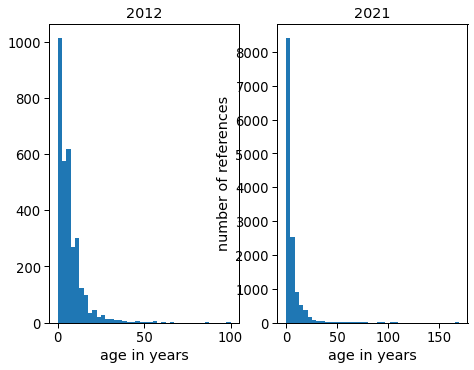

In [93]:
#own code!
#creating two histograms - do want the y label to be on the far left side, but not shabby for now..
plt.rcParams["figure.figsize"] = [7.50, 5.50]
#plt.rcParams["figure.autolayout"] = True

data = {'2012': age(dic2012, 2012)}
data1 = {'2021': age(dic2021, 2021)}
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2)

ax0.hist(data.values(), bins = 40)
ax0.set_title('2012')
ax0.set_xlabel('age in years')

ax1.hist(data1.values(), bins = 40)
ax1.set_title('2021')
#ax1.set_ylabel('number of references')

#fig, ax = plt.subplots()
#ax.hist(data.values(), bins = 40)


#plt.title('ages of references')
plt.xlabel('age in years')
plt.ylabel('number of references')
plt.savefig('histograms of age')
plt.show()


In [94]:
#code from acl, with minor details changed, comments have been added appropriately!
AGG_MAX = 15 

# aggregate citations >= AGG_MAX years old
aggdf = df.copy()
aggdf['cited_age'] = df['cited_age'].apply(lambda x: min(x, AGG_MAX))

# Count citations by year & cited_age
aggcounts = aggdf.groupby(['year', 'cited_age']).count()
aggcounts = aggcounts.reset_index().filter(items=['year', 'cited_age', 'venue'])
aggcounts.columns.values[-1] = "count"
aggcounts['count'] = aggcounts['count'].astype(float)

# normalize by total no. of *papers* in year
pfactor = df['paper_id'].groupby(df['year']).nunique('paper_id').reset_index() #pfactor definition added from previous acl code
aggpcounts = aggcounts.apply(lambda x: [x[0], x[1], x[2] / float(pfactor[pfactor['year']==x[0]]['paper_id'])], axis=1, result_type='broadcast')

# cumulative count of citations of age X or older
# need to reverse first so we start from the oldest...
aggpcounts = aggpcounts.sort_values(by='cited_age', ascending=False)
# then cumulatively sum up, for each year individually
aggpcounts['cumcount'] = aggpcounts.groupby('year')['count'].transform(pd.Series.cumsum)

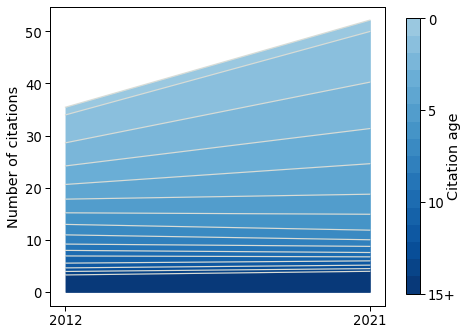

In [95]:
sns.set_context("paper", font_scale=1.5)
palette = sns.color_palette("Blues", n_colors=AGG_MAX+10)[-(AGG_MAX+1):]
linepal = [sns.xkcd_rgb["light grey"]] * (AGG_MAX+1)
ax = sns.lineplot(data=aggpcounts, x='year', y='cumcount', hue='cited_age', legend=None, palette=linepal)
ax.get_xaxis().set_visible(False) #I added this line

x = [2012, 2021] #changed the list for x to match my data
aggpcounts = aggpcounts.sort_values(by='year', ascending=True)
for i in range(AGG_MAX):
    y1 = aggpcounts[aggpcounts['cited_age'] == i]['cumcount']
    y2 = aggpcounts[aggpcounts['cited_age'] == (i + 1)]['cumcount']
    plt.fill_between(x, y1, y2, color=palette[i])

y1 = aggpcounts[aggpcounts['cited_age'] == AGG_MAX]['cumcount']
y2 = [0] * len(y1)
plt.fill_between(x, y1, y2, color=palette[AGG_MAX])

from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
cbar = plt.colorbar(
    ScalarMappable(
        cmap=ListedColormap(palette),
        norm=Normalize(vmin=0, vmax=AGG_MAX)
    ),
    ticks=[0, 5, 10, AGG_MAX],
    shrink=0.92
)

cbar.ax.invert_yaxis()
cbar.ax.set_yticklabels(["0","5","10","15+"])
cbar.set_label("Citation age", labelpad=-9)

ax.get_xaxis().set_visible(True) #I added this line too
ax.set_xlabel("")
ax.set_xticks([2012, 2021]) #again updated x to match my data
plt.xticks(rotation=0) #changed the rotation from 45 to 0

ax.set_ylabel("Number of citations")

if True:
    plt.savefig('iceberg', bbox_inches='tight') #changed from .pgf to nothing which saves as a png


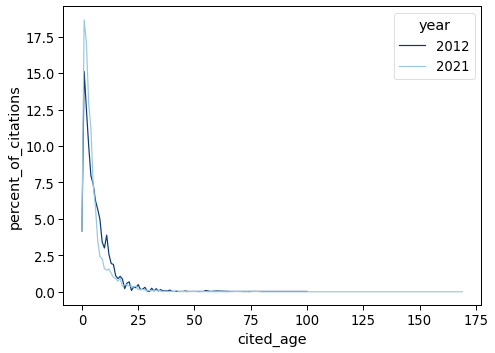

In [103]:
#code from acl repo! 
# Count citations by year & cited_age
counts = df.groupby(['year', 'cited_age']).count()
counts = counts.reset_index().filter(items=['year', 'cited_age', 'venue'])
counts.columns.values[-1] = "count"


# Normalize by total no. of citations in year
nfactor = df.groupby(['year']).count().reset_index()
counts['count'] = counts['count'].astype(float)
counts['percent_of_citations'] = counts.apply(lambda x: 100 * x[2] / float(nfactor[nfactor['year']==x[0]]['paper_id']), axis=1)

#adding the palette call to change the colour of the graph
sns.lineplot(data=counts, x='cited_age', y='percent_of_citations', hue='year', legend='full', palette= ['#083979', '#9AC8E0'])


plt.savefig('percent of citations vs age of citations')